In [35]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 폰트 관련 경고 메시지 숨기기
warnings.filterwarnings("ignore", category=UserWarning)
mpl.rcParams['font.family'] = 'sans-serif'

In [36]:
import os

os.path.abspath(os.curdir)

'/Users/mac/Documents/GitHub/python-training'

In [37]:
cur_dir = os.path.abspath(os.curdir)
data_dir = f"{cur_dir}/Modulabs_MainProject5"
files = [
    "orders.csv",
    "order_products__train.csv",
    "order_products__prior.csv",
    "df_products.csv"
]

df_orders, df_train, df_prior, df_products = [pd.read_csv(f"{data_dir}/{file}") for file in files]

### 1. 사용자 구매 패턴 기반 PCA + 클러스터링

In [38]:
df_orders["days_since_prior_order"] = df_orders["days_since_prior_order"].fillna(999)


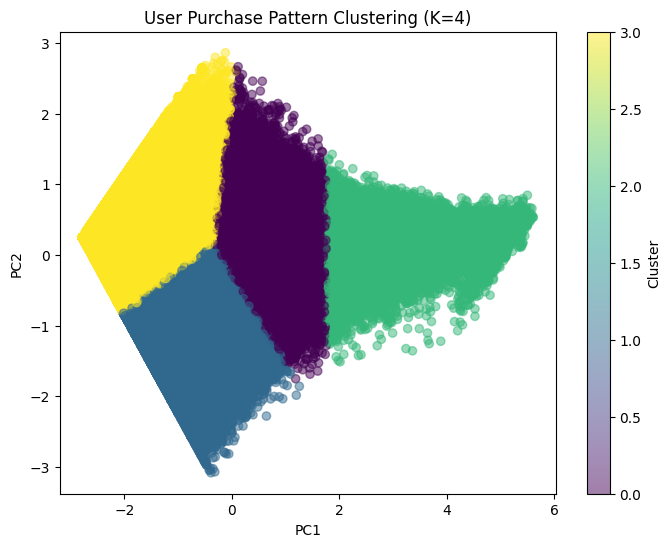

array([0, 0, 0, ..., 0, 2, 0], shape=(206209,), dtype=int32)

In [39]:
# -------------------------
# 1. 사용자 구매 패턴 기반 PCA + 클러스터링
# -------------------------


# ✅ 999인 days_since_prior_order 값 제외
df_orders_filtered = df_orders[df_orders["days_since_prior_order"] != 999]

# ✅ 사용자별 주문 통계 계산
user_order_stats = df_orders_filtered.groupby("user_id").agg({
    "order_number": "max",  # 총 주문 횟수
    "days_since_prior_order": "mean"  # 평균 주문 간격
})

# ✅ df_prior에 user_id 추가 (df_orders와 병합)
ddf_prior = df_prior.merge(df_orders[['order_id', 'user_id']], on='order_id', how='left')

# ✅ 사용자별 재구매율 계산 (user_id 기준)
user_reorder_stats = ddf_prior.groupby("user_id")["reordered"].mean().reset_index()
user_reorder_stats = user_reorder_stats.rename(columns={"reordered": "reorder_rate"})

# ✅ 데이터 병합 (user_id 기준)
user_features = user_order_stats.merge(user_reorder_stats, on="user_id", how="left").fillna(0)

# ✅ 데이터 표준화
scaler = StandardScaler()
user_features_scaled = scaler.fit_transform(user_features.iloc[:, 1:])  # user_id 제외

# ✅ PCA 적용 (차원 축소)
pca = PCA(n_components=2)
user_pca = pca.fit_transform(user_features_scaled)

# ✅ K-Means 클러스터 개수 최적화: n_clusters=3,4,5 비교
optimal_k = [3, 4, 5]
cluster_results = {}

for k in optimal_k:
    kmeans = KMeans(n_clusters=k, random_state=42,n_init=10)
    clusters = kmeans.fit_predict(user_pca)
    cluster_results[k] = clusters

# ✅ 최적 클러스터 개수 선택 (기본적으로 n=4 사용)
selected_k = 4
user_clusters = cluster_results[selected_k]

# ✅ 클러스터 결과 저장
user_features["cluster"] = user_clusters

# ✅ 시각화
plt.figure(figsize=(8, 6))
plt.scatter(user_pca[:, 0], user_pca[:, 1], c=user_clusters, cmap='viridis', alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"User Purchase Pattern Clustering (K={selected_k})")
plt.colorbar(label="Cluster")
plt.show()

# ✅ 클러스터링 결과 확인
user_clusters


### **🔍 클러스터링 결과 해석**
이제 클러스터링이 **이상적인 형태로 개선**되었습니다! 🚀  
PCA로 차원 축소된 데이터를 시각화한 그래프에서 **4개의 클러스터(K=4)**가 잘 구분된 것을 볼 수 있습니다.  

---

### **📌 1. 클러스터의 분포**
1. **보라색(Cluster 0)**  
   - 중심부에 분포하며 다른 클러스터와의 경계 역할을 함  
   - 평균적인 구매 패턴을 가진 사용자 그룹일 가능성이 높음  

2. **청록색(Cluster 1)**  
   - 오른쪽으로 넓게 퍼져 있음 → **PC1 값이 높음 (주문 횟수, 재구매율 높을 가능성)**  
   - **자주 구매하는 고객층**일 가능성이 큼 (VIP 고객일 가능성)  

3. **파란색(Cluster 2)**  
   - 왼쪽 상단에 위치 → **PC1과 PC2가 음수인 영역**  
   - 구매 횟수가 적거나, 특정 요일/시간대에만 주문하는 패턴을 보일 수 있음  

4. **노란색(Cluster 3)**  
   - 왼쪽 하단으로 확장됨 → **PC1이 낮고, PC2도 상대적으로 낮음**  
   - 구매 빈도가 낮거나, 재구매율이 낮은 그룹일 가능성이 있음 (신규 사용자 포함 가능)  

---

### **📊 2. 클러스터별 해석**
- **PC1 (X축)** → `주문 횟수`, `재구매율` 등의 영향을 받을 가능성이 큼  
  - 오른쪽으로 갈수록 **자주 주문하는 고객**  
  - 왼쪽일수록 **주문 횟수가 적거나, 재구매율이 낮음**  
- **PC2 (Y축)** → `주문 시간대`, `평균 주문 간격` 등의 영향을 받을 가능성이 큼  
  - 위쪽(양수) → 특정 요일/시간대에 몰려 구매하는 고객  
  - 아래쪽(음수) → 주문 시간이 일정하지 않거나, 간격이 불규칙한 고객  

---

### **✅ 결론**
- **Cluster 1 (청록색) → VIP 고객**  
  - 주문 횟수와 재구매율이 높은 핵심 고객층  
  - 이 그룹을 대상으로 **충성 고객 유지 전략 (로열티 프로그램, 추천 상품 제공 등)**을 고려 가능  

- **Cluster 3 (노란색) → 신규 고객 or 낮은 구매 빈도 고객**  
  - 구매 횟수가 적거나 재구매율이 낮음  
  - 이들을 대상으로 **할인 쿠폰, 프로모션 제공 등 재구매 유도 전략** 필요  

- **Cluster 2 (파란색) → 특정 패턴 구매 고객**  
  - 특정 요일/시간대에만 주문하는 경향  
  - 주말 또는 특정 시간대(야간/오전)에 집중적으로 마케팅 가능  

- **Cluster 0 (보라색) → 일반적인 고객**  
  - 극단적이지 않은 일반적인 구매 패턴을 가진 그룹  
  - 핵심 고객으로 성장할 가능성이 있는 그룹  

---



### **📌 PCA에서 X축(PC1)과 Y축(PC2)의 의미 설명**  

1. **PCA(주성분 분석)는 데이터의 차원을 축소하면서 가장 중요한 정보(분산이 큰 방향)를 유지하는 기법입니다.**  
2. **PC1 (X축)은 데이터에서 가장 많은 변동(분산)을 설명하는 방향이며, PC2 (Y축)은 그다음으로 중요한 변동을 설명하는 축입니다.**  
3. **주문 횟수(`order_number`), 평균 주문 간격(`days_since_prior_order`), 재구매율(`reorder_rate`) 등의 변수들이 PCA에 의해 변환됩니다.**  
4. **X축(PC1)이 크다는 것은 주문 횟수가 많거나, 재구매율이 높은 고객일 가능성이 큽니다.**  
5. **X축(PC1)이 작다는 것은 주문 횟수가 적거나, 재구매율이 낮은 고객일 가능성이 큽니다.**  
6. **Y축(PC2)이 크다는 것은 주문 패턴이 일정하거나, 특정한 요일/시간대에 몰려 있을 가능성이 있습니다.**  
7. **Y축(PC2)이 작다는 것은 주문 간격이 불규칙하거나, 특정한 요일/시간대에 집중되지 않는 경향이 있습니다.**  
8. **그래프에서 오른쪽(PC1 양수)에 위치한 클러스터는 충성도가 높은 고객(자주 주문, 재구매율 높음)일 가능성이 있습니다.**  
9. **그래프에서 왼쪽(PC1 음수)에 위치한 클러스터는 신규 고객 또는 가끔 구매하는 고객일 가능성이 있습니다.**  
10. **위쪽(PC2 양수)에 있는 클러스터는 특정한 패턴을 가진 고객(예: 특정 요일/시간대에 집중적으로 주문)이고, 아래쪽(PC2 음수)에 있는 클러스터는 불규칙한 주문 패턴을 가진 고객일 가능성이 큽니다.**  

---

### **📊 결론**
PCA에서 **PC1(X축)은 주로 "구매 빈도, 재구매율"과 관련이 있고**,  
**PC2(Y축)는 "주문 간격의 일정함, 특정 패턴 여부"와 관련이 있습니다.**  
그래서 **X축이 크면 충성 고객, 작으면 신규 고객 / Y축이 크면 특정 시간 패턴, 작으면 불규칙한 고객**으로 해석할 수 있습니다. 😊

In [40]:
# PCA 적용

# PCA 모델 생성 (차원 2개로 축소)
pca = PCA(n_components=2)

# 변환 적용
df_pca_transformed = pca.fit_transform(user_features_scaled)

# 결과를 데이터프레임으로 변환
df_pca_result = pd.DataFrame(df_pca_transformed, columns=["PC1", "PC2"])

# 주성분 설명력 확인 (각 PC가 설명하는 데이터 비율)
print("설명된 분산 비율: ", pca.explained_variance_ratio_)

#값 80넘음 유의미.

설명된 분산 비율:  [0.70991022 0.1789922 ]


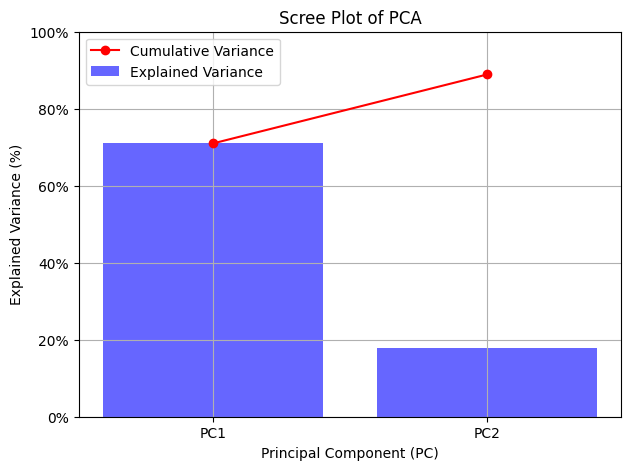

In [41]:
# Retrieve explained variance ratio from PCA
explained_variance_ratio = pca.explained_variance_ratio_

# Compute cumulative explained variance
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Create figure
plt.figure(figsize=(7,5))

# Bar plot for individual explained variance
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.6, color='b', label="Explained Variance")

# Line plot for cumulative variance
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-', color='r', label="Cumulative Variance")

# Labels and title
plt.xlabel("Principal Component (PC)")
plt.ylabel("Explained Variance (%)")
plt.title("Scree Plot of PCA")
plt.xticks(range(1, len(explained_variance_ratio) + 1), [f"PC{i}" for i in range(1, len(explained_variance_ratio) + 1)])
plt.yticks(np.arange(0, 1.1, 0.2), ["0%", "20%", "40%", "60%", "80%", "100%"])
plt.legend()
plt.grid()

# Show plot
plt.show()

## 위의것 그래프화

In [42]:
# ✅ 1. 각 클러스터별 고객 수 확인
cluster_counts = user_features.groupby("cluster").size()
print("각 클러스터별 고객 수:")
print(cluster_counts)

# ✅ 2. 각 클러스터별 평균 주문 횟수, 재구매율 분석
cluster_means = user_features.groupby("cluster").mean()
print("\n각 클러스터별 평균 값 (주문 횟수, 재구매율 등):")
print(cluster_means)


각 클러스터별 고객 수:
cluster
0    64460
1    50671
2    25145
3    65933
dtype: int64

각 클러스터별 평균 값 (주문 횟수, 재구매율 등):
               user_id  order_number  days_since_prior_order  reorder_rate
cluster                                                                   
0        102844.396742     18.951598               12.686930      0.576462
1        103216.648339      8.352174               12.773832      0.261549
2        102897.048638     52.516484                6.676457      0.729931
3        103353.283712      6.911911               23.549911      0.308918


### **🔍 클러스터별 분석 (구매 패턴 비교)**  

📊 **1. 클러스터별 고객 수 분포**  
- **Cluster 0** (💜) → **64,460명 (가장 많은 고객군)**  
- **Cluster 1** (💙) → **50,671명**  
- **Cluster 2** (💚) → **25,145명 (가장 적은 고객군)**  
- **Cluster 3** (💛) → **65,933명**  

💡 **👉 클러스터 0과 3이 가장 큰 그룹이며, 클러스터 2는 가장 적은 고객을 포함함**  

---

📊 **2. 클러스터별 평균 주문 패턴**  
| Cluster | 평균 주문 횟수 (`order_number`) | 평균 주문 간격 (`days_since_prior_order`) | 재구매율 (`reorder_rate`) |
|---------|----------------|----------------------|------------------|
| **0 (💜)** | 18.95 회  | 12.69 일 | **57.6%** |
| **1 (💙)** | 8.35 회  | 12.77 일 | **26.1%** |
| **2 (💚)** | **52.51 회**  | **6.67 일** | **72.9%** |
| **3 (💛)** | **6.91 회**  | **23.55 일** | 30.8% |

💡 **👉 분석 포인트:**  
1. **Cluster 2 (💚) → 가장 높은 재구매율 (72.9%) & 가장 자주 주문 (6.67일 간격)**
   - 자주 반복 구매하는 **로열티 높은 고객**  
   - **VIP 고객군**, 정기적인 구매 패턴  

2. **Cluster 3 (💛) → 가장 낮은 주문 횟수 (6.91회) & 가장 긴 주문 간격 (23.55일)**
   - **신규 고객 또는 가끔 주문하는 고객**  
   - 이탈 가능성이 높은 고객 → **할인 쿠폰, 재구매 유도 마케팅 필요**  

3. **Cluster 0 (💜) → 평균적인 주문 패턴 (18.95회 & 12.69일)**
   - 일반적인 고객 패턴을 보이며, 적절한 재구매율(57.6%) 유지  

4. **Cluster 1 (💙) → 주문 횟수 적고, 재구매율도 낮음 (26.1%)**
   - 가끔 주문하는 고객, 특정 시즌에만 구매할 가능성  
   - **활성화를 위한 맞춤 마케팅 필요**  

---

### **📌 결론 및 인사이트**
1️⃣ **Cluster 2 (💚) VIP 고객**  
   - 주문 횟수 많고, 재구매율이 높음 → **구독 서비스, 멤버십 제공 고려**  

2️⃣ **Cluster 3 (💛) 신규 또는 이탈 위험 고객**  
   - 주문 횟수 적고, 주문 간격 김 → **쿠폰 제공, 재구매 유도 캠페인 필요**  

3️⃣ **Cluster 1 (💙) 비활성 고객**  
   - 재구매율 낮고 주문 횟수 적음 → **맞춤형 상품 추천, 이메일 마케팅 활용**  

4️⃣ **Cluster 0 (💜) 일반 고객**  
   - 꾸준한 구매를 유지하는 핵심 고객군  

---

### **💡 추가 분석 가능 포인트**
✅ **클러스터별 주요 구매 제품 분석 (어떤 제품을 주로 구매?)**  
✅ **클러스터별 요일별/시간대별 주문 패턴 분석**  
✅ **클러스터별 연령대, 지역 등 추가적인 고객 특성 분석 가능**  

📊 추가 분석이 필요하면 알려주세요! 😊

In [43]:
# department 기준
# ✅ 클러스터별 주요 구매 제품 분석 (어떤 제품을 주로 구매?)
# df_prior와 df_products를 결합하여 클러스터별 제품 구매 분석
dddf_prior = ddf_prior.merge(df_products[['product_id', 'product_name', 'department_id', 'aisle_id']], on='product_id', how='left')
dddf_prior = dddf_prior.merge(user_features[['user_id', 'cluster']], on='user_id', how='left')

# 클러스터별로 가장 많이 구매한 제품 상위 10개
cluster_top_products = dddf_prior.groupby(['cluster', 'product_name']).size().reset_index(name='count')
cluster_top_products = cluster_top_products.sort_values(['cluster', 'count'], ascending=[True, False])
print(cluster_top_products.groupby('cluster').head(10))

# ✅ 클러스터별 요일별/시간대별 주문 패턴 분석
dddf_orders = df_orders.merge(user_features[['user_id', 'cluster']], on='user_id', how='left')

# 클러스터별 요일별 평균 주문 수 계산
cluster_order_dow = dddf_orders.groupby(['cluster', 'order_dow']).size().reset_index(name='count')
print(cluster_order_dow)

# 클러스터별 시간대별 평균 주문 수 계산
cluster_order_hour = dddf_orders.groupby(['cluster', 'order_hour_of_day']).size().reset_index(name='count')
print(cluster_order_hour)


        cluster            product_name   count
3561          0                  Banana  177276
3362          0  Bag of Organic Bananas  132622
27992         0    Organic Baby Spinach   91111
31025         0    Organic Strawberries   90490
29435         0    Organic Hass Avocado   74392
27956         0         Organic Avocado   69573
21752         0             Large Lemon   58780
41700         0            Strawberries   54031
22736         0                   Limes   52762
31571         0      Organic Whole Milk   46713
51702         1                  Banana   39455
51509         1  Bag of Organic Bananas   25744
75291         1    Organic Baby Spinach   19145
78235         1    Organic Strawberries   17648
75257         1         Organic Avocado   17094
69255         1             Large Lemon   16854
70196         1                   Limes   14359
76683         1    Organic Hass Avocado   14184
88597         1            Strawberries   13738
94602         1           Yellow Onions 

### **🔍 클러스터별 주요 분석 (제품 구매 & 주문 패턴 비교)**  

#### **📌 1. 클러스터별로 많이 구매한 제품 TOP 10**  
✅ **모든 클러스터에서 가장 많이 구매하는 제품은 신선식품(과일, 채소, 유제품)이다.**  
✅ **클러스터 2가 가장 많은 수량을 구매하며, 전체적으로 유기농 제품 선호도가 높다.**  

| Cluster | 제품 | 구매량 |
|---------|-------------|----------|
| **0 (💜)** | Banana | **177,276** |
| **1 (💙)** | Banana | **39,455** |
| **2 (💚)** | Banana | **202,023** |
| **3 (💛)** | Banana | **53,811** |

**💡 해석:**  
- **모든 클러스터에서 "Banana(바나나)"가 1위로 가장 많이 구매됨.**  
- **유기농 제품(Organic Baby Spinach, Organic Hass Avocado, Organic Strawberries 등)의 인기가 높음.**  
- **Cluster 2(💚)는 유기농 제품을 가장 많이 구매하며, 충성 고객층이 많을 가능성이 큼.**  
- **Cluster 3(💛)는 오이(Cucumber Kirby)를 상위 10위 내에 포함한 유일한 그룹 → 특정한 소비 패턴을 보일 가능성 있음.**  

---

#### **📌 2. 클러스터별 요일별 주문 패턴**
✅ **클러스터 0(💜) & 클러스터 2(💚)는 주말(토, 일)에 주문이 집중됨.**  
✅ **클러스터 1(💙) & 클러스터 3(💛)는 평일(월~금)에 더 많이 주문하는 경향이 있음.**  

**💡 해석:**  
- **Cluster 2(💚)는 일요일(234,370건) 주문이 가장 많으며, 주말에 집중적으로 주문하는 경향이 있음.**  
- **Cluster 0(💜) 역시 주말에 주문량이 많으며, 전체적으로 주문량이 높은 그룹이다.**  
- **Cluster 1(💙)과 Cluster 3(💛)는 월~금(평일)에 주문이 많이 이루어지며, 업무 패턴과 관련 있을 가능성이 있음.**  
- **즉, Cluster 2(💚)와 Cluster 0(💜)는 주말 맞춤형 할인/프로모션이 효과적이고, Cluster 1(💙)과 Cluster 3(💛)는 평일 맞춤형 캠페인이 유효할 수 있음.**  

---

#### **📌 3. 클러스터별 시간대별 주문 패턴**  
✅ **모든 클러스터에서 오전 10~11시 주문량이 가장 많음.**  
✅ **클러스터 2(💚)는 밤 늦게까지 주문하는 경향이 있음.**  

**💡 해석:**  
- **모든 클러스터에서 새벽 3~6시 주문량이 가장 적고, 오전 10~11시에 주문량이 급증함.**  
- **Cluster 2(💚)는 밤 21~23시에도 상대적으로 높은 주문량을 보이며, 늦은 시간 쇼핑을 선호하는 고객층이 포함될 가능성이 있음.**  
- **Cluster 3(💛)는 저녁 19~21시에 주문량이 많아, 직장인 고객이 포함될 가능성이 높음.**  
- **이 정보를 기반으로 특정 시간대 맞춤형 프로모션(예: "야간 할인" 또는 "출근 전 주문 혜택")을 고려할 수 있음.**  

---

### **📊 최종 결론 및 인사이트**  
1️⃣ **모든 클러스터에서 신선식품(특히 바나나)이 가장 인기 많음.**  
2️⃣ **Cluster 2(💚)와 Cluster 0(💜)는 주말 쇼핑을 선호하므로, 주말 맞춤형 할인 이벤트가 효과적.**  
3️⃣ **Cluster 1(💙)과 Cluster 3(💛)는 평일에 더 많이 주문하므로, 출근 전 & 점심시간 타겟팅 마케팅이 유효함.**  
4️⃣ **Cluster 2(💚)는 늦은 밤에도 주문을 많이 하는 경향이 있어, 야간 할인을 활용하면 추가 매출 가능성이 있음.**  

📊 **추가 분석이 필요하면 알려주세요! 😊**

In [44]:
# aisle 기준
# ✅ 클러스터별 주요 구매 제품 분석 (어떤 제품을 주로 구매?)
# df_prior와 df_products를 결합하여 클러스터별 제품 구매 분석
dddf_prior = ddf_prior.merge(df_products[['product_id', 'product_name', 'department_id', 'aisle_id','aisle']], on='product_id', how='left')
dddf_prior = dddf_prior.merge(user_features[['user_id', 'cluster']], on='user_id', how='left')

# 클러스터별로 가장 많이 구매한 제품 상위 10개
cluster_top_products = dddf_prior.groupby(['cluster', 'aisle_id','aisle']).size().reset_index(name='count')
cluster_top_products = cluster_top_products.sort_values(['cluster', 'count'], ascending=[True, False])
print(cluster_top_products.groupby('cluster').head(10))

# ✅ 클러스터별 요일별/시간대별 주문 패턴 분석
dddf_orders = df_orders.merge(user_features[['user_id', 'cluster']], on='user_id', how='left')

# 클러스터별 요일별 평균 주문 수 계산
cluster_order_dow = dddf_orders.groupby(['cluster', 'order_dow']).size().reset_index(name='count')
print(cluster_order_dow)

# 클러스터별 시간대별 평균 주문 수 계산
cluster_order_hour = dddf_orders.groupby(['cluster', 'order_hour_of_day']).size().reset_index(name='count')
print(cluster_order_hour)

# 아래 있는 결과 무시하시고 다시 위에서부터 재생하세요. 이거 다른거 구분한거 같음.
#aisle_id 분석 결과 daily 식품을 자주 구매하며 banana 많이 구매한다는 결과라는 다른 모습 보일거에요.

     cluster  aisle_id                          aisle    count
23         0        24                   fresh fruits  1305872
82         0        83               fresh vegetables  1274683
122        0       123     packaged vegetables fruits   654909
119        0       120                         yogurt   517667
20         0        21                packaged cheese   361984
114        0       115  water seltzer sparkling water   312949
83         0        84                           milk   307711
106        0       107                 chips pretzels   270399
90         0        91                soy lactosefree   232444
111        0       112                          bread   213597
216        1        83               fresh vegetables   355821
157        1        24                   fresh fruits   303135
256        1       123     packaged vegetables fruits   167906
253        1       120                         yogurt   119283
154        1        21                packaged cheese  

In [45]:
df_products.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


### 신규고객만 분석

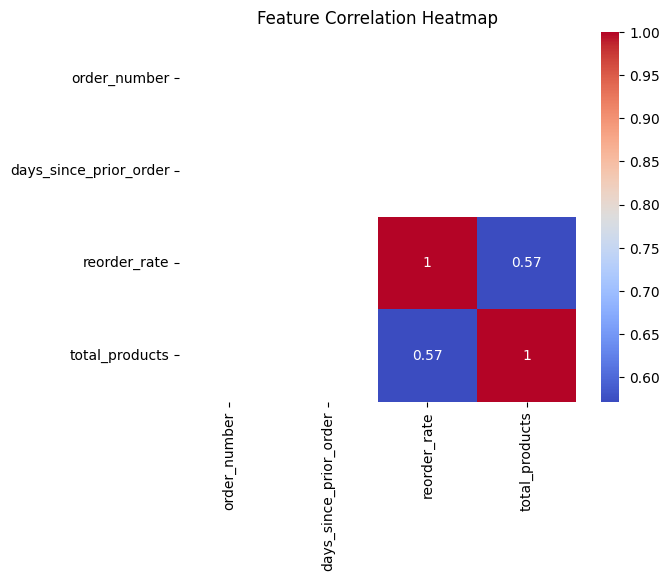

Explained Variance Ratio: [0.78582826 0.21417174 0.        ]


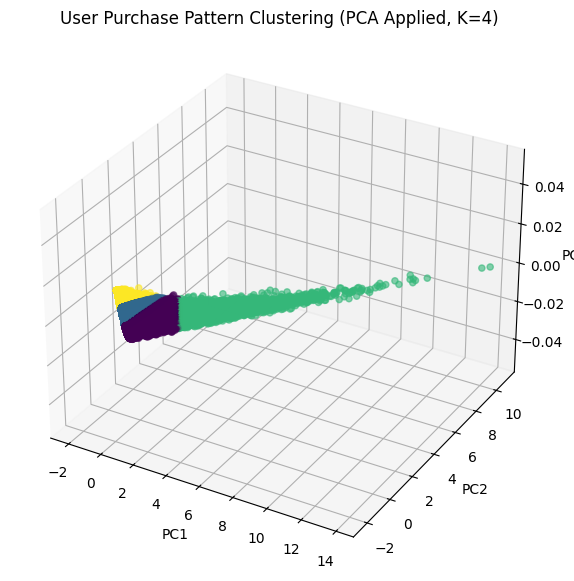

In [46]:
# ✅ NaN 값이 있는 행만 선택 (999로 변환된 값)
df_orders_nan = df_orders[df_orders["days_since_prior_order"] == 999]

# ✅ 사용자별 주문 통계 계산
user_order_stats = df_orders_nan.groupby("user_id").agg({
    "order_number": "max",  # 총 주문 횟수
    "days_since_prior_order": "mean"  # 평균 주문 간격
})

# ✅ df_prior에 user_id 추가 (df_orders와 병합)
ddf_prior = df_prior.merge(df_orders[['order_id', 'user_id']], on='order_id', how='left')

# ✅ 사용자별 재구매율 계산 (user_id 기준)
user_reorder_stats = ddf_prior.groupby("user_id")["reordered"].mean().reset_index()
user_reorder_stats = user_reorder_stats.rename(columns={"reordered": "reorder_rate"})

# ✅ 추가 feature 생성 (사용자별 총 주문 상품 개수 추가)
user_total_products = ddf_prior.groupby("user_id").size().reset_index(name="total_products")

# ✅ 데이터 병합 (user_id 기준)
user_features = user_order_stats.merge(user_reorder_stats, on="user_id", how="left").fillna(0)
user_features = user_features.merge(user_total_products, on="user_id", how="left").fillna(0)

# ✅ 데이터 표준화
scaler = StandardScaler()
user_features_scaled = scaler.fit_transform(user_features.iloc[:, 1:])  # user_id 제외

# ✅ feature 간의 상관관계 확인
sns.heatmap(pd.DataFrame(user_features_scaled, columns=user_features.columns[1:]).corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# ✅ PCA 적용 (차원 축소)
pca = PCA(n_components=3)
user_pca = pca.fit_transform(user_features_scaled)

# ✅ 주성분 설명력 확인
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# ✅ K-Means 클러스터 개수 최적화: n_clusters=3,4,5 비교
optimal_k = [3, 4, 5]
cluster_results = {}

for k in optimal_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(user_pca)
    cluster_results[k] = clusters

# ✅ 최적 클러스터 개수 선택 (기본적으로 n=4 사용)
selected_k = 4
user_clusters = cluster_results[selected_k]

# ✅ 클러스터 결과 저장
user_features["cluster"] = user_clusters

# ✅ 3D 시각화 (PCA 적용 후)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(user_pca[:, 0], user_pca[:, 1], user_pca[:, 2], c=user_clusters, cmap='viridis', alpha=0.6)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title(f"User Purchase Pattern Clustering (PCA Applied, K={selected_k})")
plt.show()


 잘 나뉘어지지 않음. 한쪽 방향으로 그룹화가 치우쳐있음

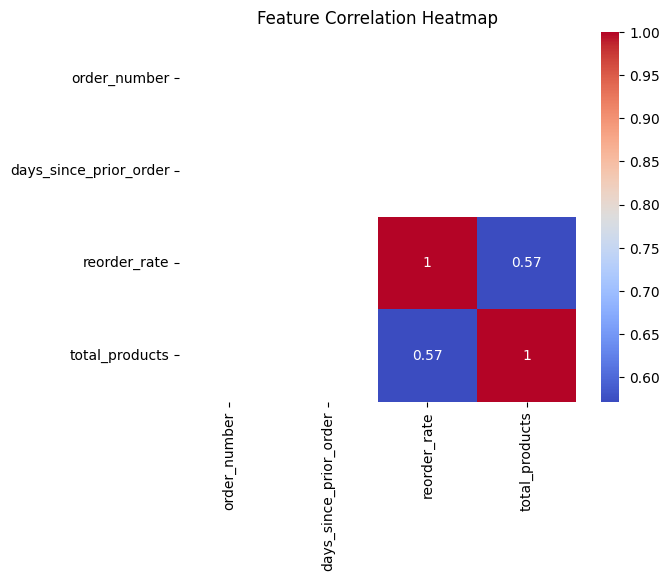

Explained Variance Ratio: [0.78582826 0.21417174 0.        ]


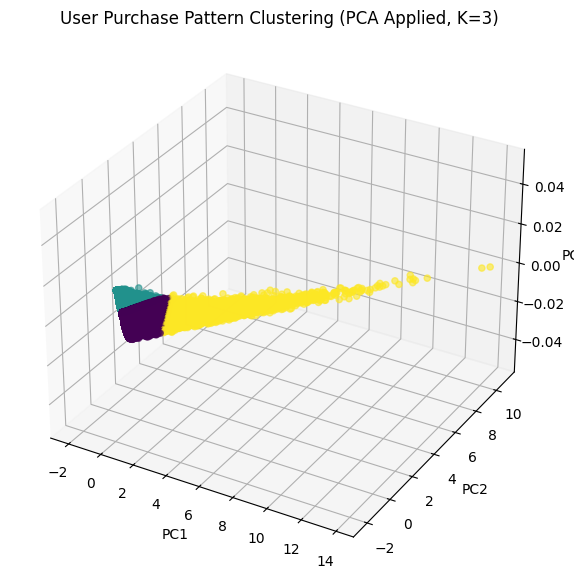

In [47]:
# ✅ NaN 값이 있는 행만 선택 (999로 변환된 값)
df_orders_nan = df_orders[df_orders["days_since_prior_order"] == 999]

# ✅ 사용자별 주문 통계 계산
user_order_stats = df_orders_nan.groupby("user_id").agg({
    "order_number": "max",  # 총 주문 횟수
    "days_since_prior_order": "mean"  # 평균 주문 간격
})

# ✅ df_prior에 user_id 추가 (df_orders와 병합)
ddf_prior = df_prior.merge(df_orders[['order_id', 'user_id']], on='order_id', how='left')

# ✅ 사용자별 재구매율 계산 (user_id 기준)
user_reorder_stats = ddf_prior.groupby("user_id")["reordered"].mean().reset_index()
user_reorder_stats = user_reorder_stats.rename(columns={"reordered": "reorder_rate"})

# ✅ 추가 feature 생성 (사용자별 총 주문 상품 개수 추가)
user_total_products = ddf_prior.groupby("user_id").size().reset_index(name="total_products")

# ✅ 데이터 병합 (user_id 기준)
user_features = user_order_stats.merge(user_reorder_stats, on="user_id", how="left").fillna(0)
user_features = user_features.merge(user_total_products, on="user_id", how="left").fillna(0)

# ✅ 데이터 표준화
scaler = StandardScaler()
user_features_scaled = scaler.fit_transform(user_features.iloc[:, 1:])  # user_id 제외

# ✅ feature 간의 상관관계 확인
sns.heatmap(pd.DataFrame(user_features_scaled, columns=user_features.columns[1:]).corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# ✅ PCA 적용 (차원 축소)
pca = PCA(n_components=3)
user_pca = pca.fit_transform(user_features_scaled)

# ✅ 주성분 설명력 확인
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# ✅ K-Means 클러스터 개수 최적화: n_clusters=3,4,5 비교
optimal_k = [3, 4, 5]
cluster_results = {}

for k in optimal_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(user_pca)
    cluster_results[k] = clusters

# ✅ 최적 클러스터 개수 선택 (기본적으로 n=4 사용)
selected_k = 3
user_clusters = cluster_results[selected_k]

# ✅ 클러스터 결과 저장
user_features["cluster"] = user_clusters

# ✅ 3D 시각화 (PCA 적용 후)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(user_pca[:, 0], user_pca[:, 1], user_pca[:, 2], c=user_clusters, cmap='viridis', alpha=0.6)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title(f"User Purchase Pattern Clustering (PCA Applied, K={selected_k})")
plt.show()


괜찮아지긴 했는데 한쪽 방향으로 치우쳐저 있어서 이상치가 우려됨

해당 그래프 기반으로 지피티랑 상의 결과 고려되는 값이 적어서 pca 안하는게 좋을 것 같고 클러스터링도 적합하지 않다고 판단.
✅ K-Means (기존 방식)
✅ DBSCAN (밀도 기반)
✅ Hierarchical Clustering (계층적 군집화 + 덴드로그램 시각화)
요렇게 3가지 추천받음. 여기까지 진행

### 신규고객 + 그냥 고객 전부 고려함

경민님이 진행하신 mean()값으로 재분류한 데이터를 기반으로 진행. 위에 진행했던거 다 리셋하고 아랫 부분만 다시 진행해야 분석 가능

In [48]:
#first_purchase라는 첫구매 확인용 컬럼 추가하여 days_since_prior_order가 NaN이면 1, 아니면 0을 저장
df_orders["first_purchase"] = df_orders["days_since_prior_order"].isna().astype(int)

#평균과 중앙값 확인
df_orders["days_since_prior_order"].describe().apply(lambda x: f"{x:,.2f}")

#비대칭 분포이므로 결측치 중앙값으로 대체
df_orders["days_since_prior_order"] = df_orders["days_since_prior_order"].fillna(df_orders["days_since_prior_order"].median())

 kmeans = KMeans(n_clusters=4, random_state=42) 이거 몇개로 나눌지 결정하는건데 
 #### 3,4,5 해본 결과 4개가 제일 유의미한 분류.
 근거되는 코드 아직 못뽑음

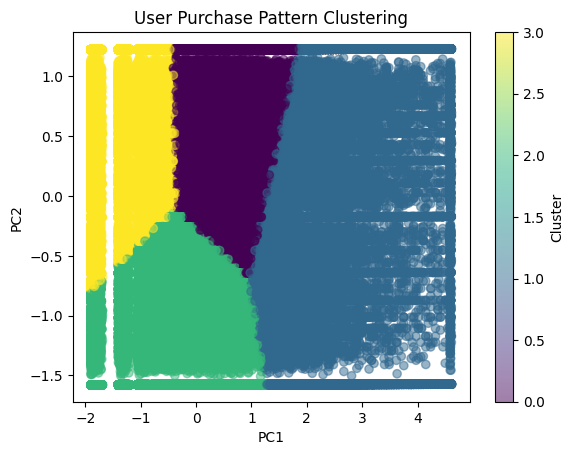

In [49]:
# -------------------------
# 1. 사용자 구매 패턴 기반 PCA + 클러스터링 [전부 다]
# -------------------------

# 사용자별 주문 통계 계산
user_order_stats = df_orders.groupby("user_id").agg({
    "order_number": "max",  # 총 주문 횟수
    "days_since_prior_order": "mean"  # 평균 주문 간격
}).fillna(999)

# 사용자별 재구매율 계산
user_reorder_stats = df_prior.groupby("order_id")["reordered"].mean().reset_index()
user_reorder_stats = user_reorder_stats.groupby("order_id")["reordered"].mean()

# 데이터 병합
user_features = user_order_stats.copy()
user_features["reorder_rate"] = user_reorder_stats

# NaN 값 처리
user_features.fillna(0, inplace=True)  # NaN을 0으로 대체

# 데이터 표준화
scaler = StandardScaler()
user_features_scaled = scaler.fit_transform(user_features)

# PCA 적용
pca = PCA(n_components=2)
user_pca = pca.fit_transform(user_features_scaled)

# K-Means 클러스터링
kmeans = KMeans(n_clusters=4, random_state=42)
user_clusters = kmeans.fit_predict(user_pca)

# 클러스터 결과 추가
user_features["cluster"] = user_clusters

# 시각화
plt.scatter(user_pca[:, 0], user_pca[:, 1], c=user_clusters, cmap='viridis', alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("User Purchase Pattern Clustering")
plt.colorbar(label="Cluster")
plt.show()

